Creating first  model for wind generation prediction

* Get data
* Preprocessing
* Format data( test - train split)
* Build model
* Test model


In [13]:
# Load libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import models as mdl
import preprocessing as pre
import plot_creation as plt_data
import model_data_generation as dataGen
import numpy as np
import pandas as pd
# create object to plot data
create_model = mdl.CreateModel()


#### Get data

In [72]:
WIND = 'Wind'
# path
path = "\Path_of_energy_data"
year = [ '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
month = ['01_Jan', '02_Feb', '03_Mar', '04_Apr', '05_May', '06_Jun', '07_Jul', '08_Aug', '09_Sep', '10_Oct', '11_Nov', '12_Dec']

# load data
df = pre.load_data(path, year, typ = WIND)


------------------------------------------------------------

Shape of the data:
(525752, 4)

------------------------------------------------------------
 First 5 rows: 

            DATE & TIME  FORECAST WIND(MW)   ACTUAL WIND(MW)      REGION
0  1 January 2014 00:00                  -              1386  All Island
1  1 January 2014 00:15                  -              1348  All Island
2  1 January 2014 00:30                  -              1272  All Island
3  1 January 2014 00:45                  -              1273  All Island
4  1 January 2014 01:00                  -              1236  All Island


#### Preprocessing

In [73]:
df_ire , df = pre.data_preprocess(df, typ=WIND)


------------------------------------------------------------
 Column Names:
Index(['DATE & TIME', ' FORECAST WIND(MW)', '  ACTUAL WIND(MW)', ' REGION'], dtype='object')

------------------------------------------------------------

 Dataset information:
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 525752 entries, 0 to 2879
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   DATE & TIME         525752 non-null  object        
 1    FORECAST WIND(MW)  478178 non-null  object        
 2     ACTUAL WIND(MW)   525586 non-null  object        
 3    REGION             525752 non-null  object        
 4   datetime            525752 non-null  datetime64[ns]
 5   year                525752 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 28.1+ MB
None
-------------------------------------------

##### visualisation

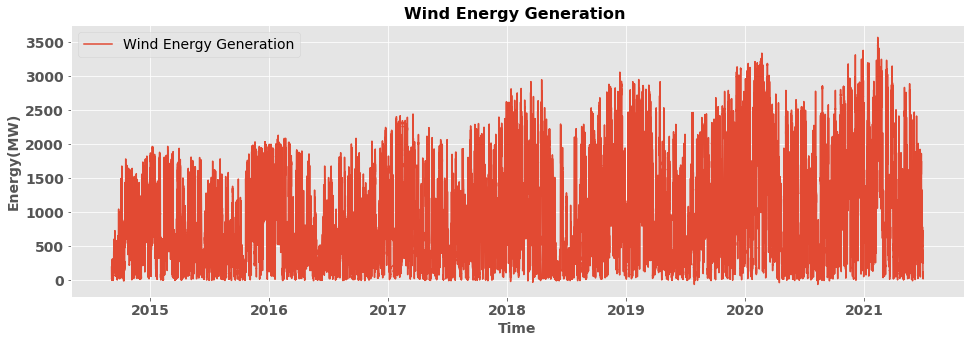

In [ ]:
plt.figure(figsize=(16, 5))
plt_data.plot_time_series(timesteps=df_ire.index, values=df_ire['Wind_G'],title='Wind Energy Generation ', label= 'Wind Energy Generation')

In [ ]:
weekly_ire = df.set_index('datetime').resample('1W').mean()['Wind_G']
weekly_ire = weekly_ire.dropna()
weekly_ire.head()

datetime
2014-01-05    1080.102083
2014-01-12     880.668155
2014-01-19     472.689732
2014-01-26    1072.993304
2014-02-02    1120.911458
Freq: W-SUN, Name: Wind_G, dtype: float64

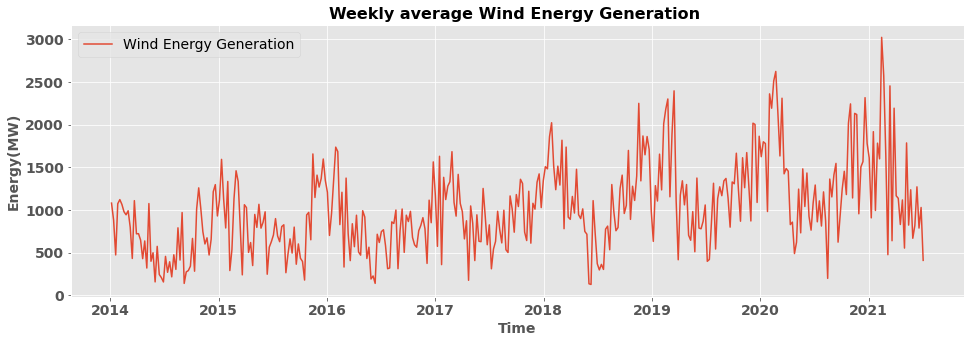

In [ ]:
plt.figure(figsize=(16, 5))
plt_data.plot_time_series(timesteps=weekly_ire.index, values=weekly_ire,title='Weekly average Wind Energy Generation ', label= 'Wind Energy Generation')

In [ ]:
monthly_ire = df.set_index('datetime').resample('1M').mean()['Wind_G']
monthly_ire = monthly_ire.dropna()
monthly_ire.head()

datetime
2014-01-31     877.911962
2014-02-28    1058.284784
2014-03-31     749.885599
2014-04-30     568.446875
2014-05-31     514.300403
Freq: M, Name: Wind_G, dtype: float64

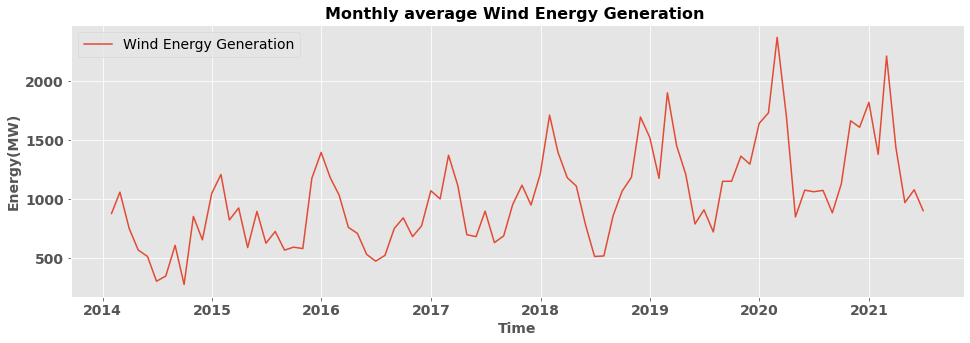

In [ ]:
plt.figure(figsize=(16, 5))
plt_data.plot_time_series(timesteps=monthly_ire.index, values=monthly_ire,title='Monthly average Wind Energy Generation ', label= 'Wind Energy Generation')

### RNN

In [ ]:
HORIZON = 25 # 6 hours data
WINDOW_SIZE = 30 
model_name= 'rnn'
batch_size = 32
norm_method ="zscore"
test_split = 0.2
learning_rate = 0.001
max_steps_per_epoch = 10000
epochs = 5
model_args = {
            "layers": 1,
            "units": 32, 
            "return_sequence": False 
        }

#### Format data-  train test split

In [ ]:
df_ire_model = df_ire[(df_ire.index.year != 2020) & (df_ire.index.year != 2021) & (df_ire.index.year != 2019)] 

# data array - converting the dataframe to array 
timesteps , data_array = dataGen.df_to_array(df_ire_model = df_ire_model, typ = WIND)

# Data normalization based on the 'normalization method'
normalied_data_array, norm_scaler = dataGen.normalize_data( 
                                                    data = data_array,
                                                    method = norm_method
                                                )                       

First-5 entry in data array :
------------------------------------------------------------
Timestamp:
 ['2014-09-04T06:00:00.000000000' '2014-09-04T06:15:00.000000000'
 '2014-09-04T06:30:00.000000000' '2014-09-04T06:45:00.000000000'
 '2014-09-04T07:00:00.000000000'] 
Wind energy generation(MW):
 [198. 184. 176. 168. 157.]


##### train test split

In [ ]:
# Train-Test split 70-30
train_split = 0.7
# 70% train, 30% test
split_size = int(train_split * len(data_array)) 

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], data_array[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], data_array[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(106127, 45484, 106127, 45484)

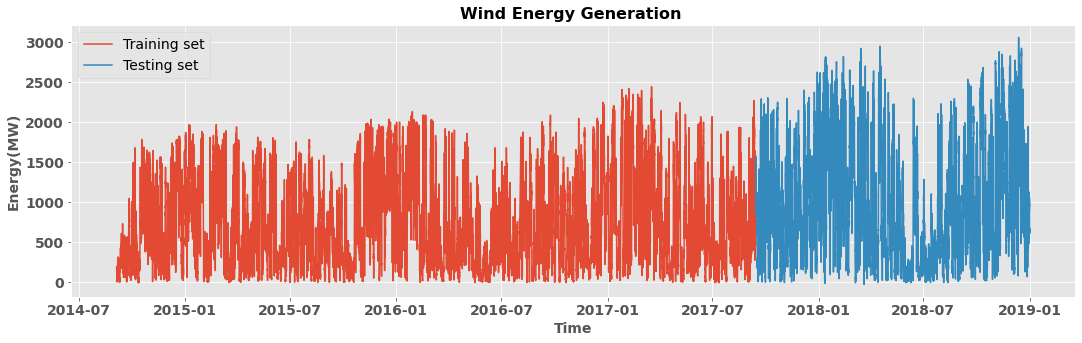

In [ ]:
plt.figure(figsize=(18, 5))
plt_data.plot_time_series(timesteps=X_train, values=y_train ,title='Wind Energy Generation ', label= 'Training set')
plt_data.plot_time_series(timesteps=X_test, values=y_test ,title='Wind Energy Generation ', label= 'Testing set')

##### Windowing the dataset 

In [ ]:
 # get windows and labels from the data array
full_windows, full_labels = dataGen.make_windows(
                                            x = normalied_data_array, 
                                            window_size = WINDOW_SIZE, 
                                            horizon=HORIZON
                                        )

# train test split of windows and labels
train_windows, test_windows, train_labels, test_labels = dataGen.make_train_test_splits(
                                                                            windows = full_windows, 
                                                                            labels = full_labels, 
                                                                            test_split = test_split
                                                                        )


Window shape: (151557, 30) 
Label shape: (151557, 25)
Train Window shape: (121245, 30) 
Train Label shape: (121245, 25) 
Test Window shape: (30312, 30) 
Test Label shape: (30312, 25)


#### Build Model 

##### model definition

In [ ]:

# Model definition
model_rnn = create_model.rnn(
            input_shape = WINDOW_SIZE,
            name = "%s_%s%s_%s_%s" %(WIND, model_name, batch_size, norm_method, test_split),
            output_size=HORIZON,
            optimizer= tf.optimizers.Adam(learning_rate=learning_rate),
            loss="mse",
            recurrent_units = [model_args["units"]] * model_args["layers"],
            return_sequences = model_args["return_sequence"]
        ) 

print('\nModel Summary:')
print(model_rnn.summary())



Model Summary:
Model: "Wind_rnn32_zscore_0.2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 30)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2016      
_________________________________________________________________
dense (Dense)                (None, 25)                825       
Total params: 2,841
Trainable params: 2,841
Non-trainable params: 0
_________________________________________________________________
None


##### model training

In [ ]:
print('\nModel Training:')

# Fit the model with 80 - 20 split
fit = create_model.fit_model(model_rnn, train_windows, train_labels, test_windows, test_labels, 
                            batch_size= batch_size, epochs=epochs, max_steps_per_epoch=max_steps_per_epoch, save_path= 'model_test_experiments')


Model Training:
INFO:tensorflow:Assets written to: model_test_experiments\Wind_rnn32_zscore_0.2\assets
INFO:tensorflow:Assets written to: model_test_experiments\Wind_rnn32_zscore_0.2\assets
INFO:tensorflow:Assets written to: model_test_experiments\Wind_rnn32_zscore_0.2\assets


##### Plot traing performance

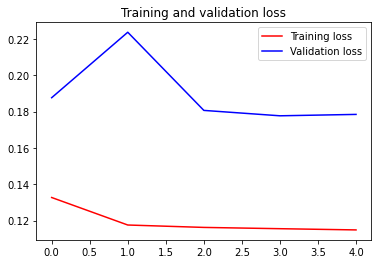

In [ ]:
# plot in training performance
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Load RNN

In [ ]:
# Load in best version of model
model_rnn = tf.keras.models.load_model("model_test_experiments/Wind_rnn32_zscore_0.2/")

### LSTM

In [ ]:
HORIZON = 25 # 6 hours data
WINDOW_SIZE = 30 
model_name= 'lstm'
batch_size = 32
norm_method ="zscore"
test_split = 0.2
learning_rate = 0.001
max_steps_per_epoch = 10000
epochs = 5
model_args = {
            "layers": 1,
            "units": 32, 
            "return_sequence": False 
        }

#### Format data-  train test split

In [ ]:
df_ire_model = df_ire[(df_ire.index.year != 2020) & (df_ire.index.year != 2021) & (df_ire.index.year != 2019)] 

# data array - converting the dataframe to array 
timesteps , data_array = dataGen.df_to_array(df_ire_model = df_ire_model, typ = WIND)

# Data normalization based on the 'normalization method'
normalied_data_array, norm_scaler = dataGen.normalize_data( 
                                                    data = data_array,
                                                    method = norm_method
                                                )      

First-5 entry in data array :
------------------------------------------------------------
Timestamp:
 ['2014-09-04T06:00:00.000000000' '2014-09-04T06:15:00.000000000'
 '2014-09-04T06:30:00.000000000' '2014-09-04T06:45:00.000000000'
 '2014-09-04T07:00:00.000000000'] 
Wind energy generation(MW):
 [198. 184. 176. 168. 157.]


##### Windowing the dataset 

In [ ]:
 # get windows and labels from the data array
full_windows, full_labels = dataGen.make_windows(
                                            x = normalied_data_array, 
                                            window_size = WINDOW_SIZE, 
                                            horizon=HORIZON
                                        )

# train test split of windows and labels
train_windows, test_windows, train_labels, test_labels = dataGen.make_train_test_splits(
                                                                            windows = full_windows, 
                                                                            labels = full_labels, 
                                                                            test_split = test_split
                                                                        )


Window shape: (238984, 30) 
Label shape: (238984, 25)
Train Window shape: (191187, 30) 
Train Label shape: (191187, 25) 
Test Window shape: (47797, 30) 
Test Label shape: (47797, 25)


#### Build Model 

##### Model definition

In [ ]:
# Model definition
model_lstm = create_model.lstm(
            input_shape = WINDOW_SIZE,
            name = "%s_%s%s_%s_%s" %(WIND, model_name, batch_size, norm_method, test_split),
            output_size=HORIZON,
            optimizer= tf.optimizers.Adam(learning_rate=learning_rate),
            loss="mse",
            recurrent_units = [model_args["units"]] * model_args["layers"],
            return_sequences = model_args["return_sequence"]
        ) 

print('\nModel Summary:')
print(model_lstm.summary())


Model Summary:
Model: "Wind_lstm32_zscore_0.2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 30)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8064      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                825       
Total params: 8,889
Trainable params: 8,889
Non-trainable params: 0
_________________________________________________________________
None


##### model training

In [ ]:
print('\nModel Training:')

# Fit the model with 80 - 20 split
fit = create_model.fit_model(model_lstm, train_windows, train_labels, test_windows, test_labels, 
                            batch_size= batch_size, epochs=epochs, max_steps_per_epoch=max_steps_per_epoch, save_path= 'model_test_experiments')


Model Training:


INFO:tensorflow:Assets written to: model_test_experiments\Wind_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Wind_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Wind_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Wind_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Wind_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Wind_lstm32_zscore_0.2\assets


##### Plot traing performance

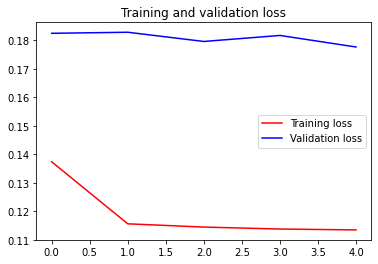

In [ ]:
# plot in training performance
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Load LSTM

In [ ]:
# Load in best version of model
model_lstm = tf.keras.models.load_model("model_test_experiments/Wind_lstm32_zscore_0.2/")

### Validation 

In [22]:
def future_pred_values(model, data):
    """
    Funtion that returns future predictions based on the windowed 'data' and 'model'
    """
    # get prediction based on model
    preds = create_model.make_preds(model, data)
    preds = preds.numpy()

    future_pred = []
    for i in range(1, len(preds)+1) :

        if i == len(preds) :
            for e in preds[i-1:i].flatten():
                future_pred.append(e)
        else :
            future_pred.append(preds[i-1:i].flatten()[0])

    return future_pred

def monthly_prediction( 
    windows,
    model_rnn,
    model_lstm,
    scaler,
    actual,
    eir_pred,
    ):
    """
    Function that makes monthly model predictions and returns evaluation results
    """
    # RNN Model prediction 
    rnn_pred = future_pred_values( model = model_rnn, data = windows)
    # denormalize prediction
    rnn_pred = scaler.inverse_transform(rnn_pred)

    # RNN Model prediction 
    lstm_pred = future_pred_values( model = model_lstm, data = windows)
    # denormalize prediction
    lstm_pred = scaler.inverse_transform(lstm_pred)


    # Eir forecast data evaluation 
    EIR_results = create_model.evaluate_preds(  y_true=actual,   y_pred=eir_pred)
    print('Eir forecast data evaluation--')
    print(EIR_results)

    # RNN model prediction evaluation 
    rnn_results = create_model.evaluate_preds(  y_true=actual, y_pred=rnn_pred)
    print('RNN Model prediction evaluation--')
    print(rnn_results)

    # LSTM model prediction evaluation 
    lstm_results = create_model.evaluate_preds(  y_true=actual, y_pred=lstm_pred)
    print('LSTM Model prediction evaluation--')
    print(lstm_results)

    return EIR_results, rnn_results, lstm_results , rnn_pred, lstm_pred 

#### MARCH

##### Prediction for the month of March-2020

In [38]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2020,
                                        prev_month = 2, # feb
                                        pred_month = 3, # mar
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
mar_windows, timesteps_mar, wind_g_mar, wind_f_mar = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2948, 30) 
Label shape: (2948, 25)


In [39]:
# prediction evaluation for month of Mar - 2020
EIR_results_mar , rnn_results_mar, lstm_results_mar, rnn_pred_mar, lstm_pred_mar = monthly_prediction( 
                                                                                    windows= mar_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_mar,
                                                                                    eir_pred = wind_f_mar
                                                                                )

Eir forecast data evaluation--
{'mae': 251.77086137281293, 'mse': 113716.65847913863, 'rmse': 337.2190066991163}
RNN Model prediction evaluation--
{'mae': 104.20496954731793, 'mse': 27158.7065100364, 'rmse': 164.79898819481994}
LSTM Model prediction evaluation--
{'mae': 82.86309070253436, 'mse': 15645.33530878912, 'rmse': 125.08131478677828}


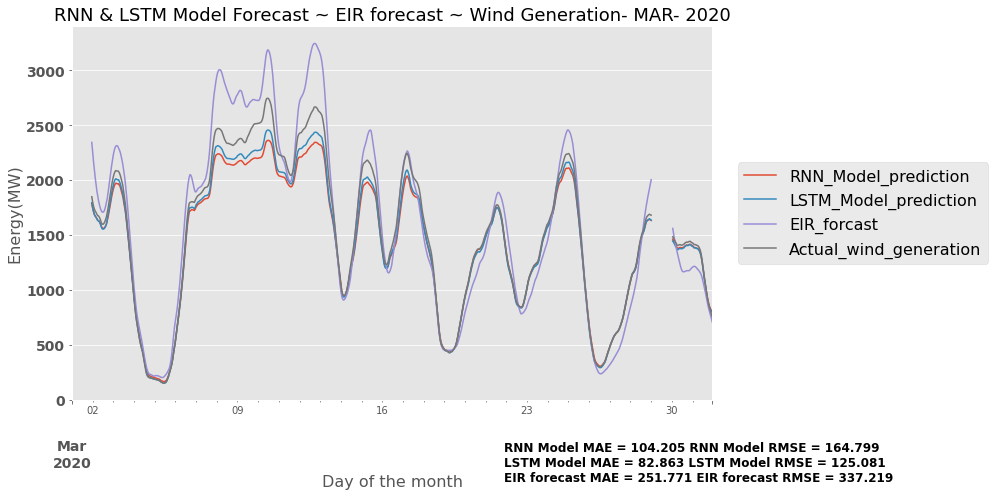

In [40]:
# Plot predictions MAR 2020
d_mar = {   'datetime': timesteps_mar,
            'RNN_Model_prediction': rnn_pred_mar,
            'LSTM_Model_prediction': lstm_pred_mar,
            'EIR_forcast': wind_f_mar,
            'Actual_wind_generation' : wind_g_mar
        }       
df_mar = pd.DataFrame(data=d_mar)

df_mar_w_rolling = df_mar.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ EIR forecast ~ Wind Generation- MAR- 2020
plt_data.plot_predictions( 
    df = df_mar_w_rolling,
    rnn_results = rnn_results_mar,
    lstm_results =  lstm_results_mar,
    EIR_results = EIR_results_mar,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- MAR- 2020",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of March-2019

In [35]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2019,
                                        prev_month = 2, # feb
                                        pred_month = 3, # mar
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
mar_windows, timesteps_mar, wind_g_mar, wind_f_mar = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2948, 30) 
Label shape: (2948, 25)


In [36]:
# prediction evaluation for month of Mar - 2019
EIR_results_mar , rnn_results_mar, lstm_results_mar, rnn_pred_mar, lstm_pred_mar = monthly_prediction( 
                                                                                    windows= mar_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_mar,
                                                                                    eir_pred = wind_f_mar
                                                                                )

Eir forecast data evaluation--
{'mae': 184.099932705249, 'mse': 69755.32604306864, 'rmse': 264.11233602970657}
RNN Model prediction evaluation--
{'mae': 74.0668991109404, 'mse': 12729.001189675593, 'rmse': 112.82287529431075}
LSTM Model prediction evaluation--
{'mae': 56.932998848474845, 'mse': 6788.703805419168, 'rmse': 82.39359080304224}


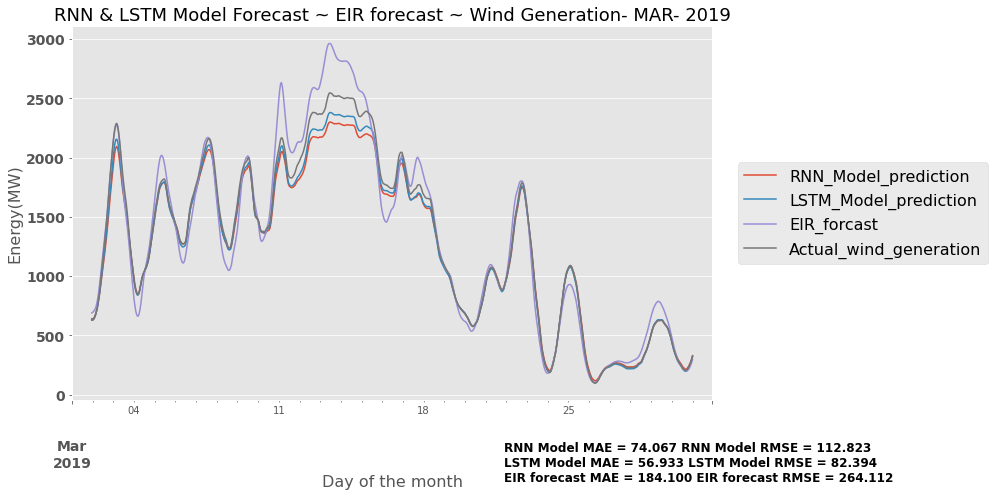

In [37]:
d_mar = {   'datetime': timesteps_mar,
            'RNN_Model_prediction': rnn_pred_mar,
            'LSTM_Model_prediction': lstm_pred_mar,
            'EIR_forcast': wind_f_mar,
            'Actual_wind_generation' : wind_g_mar
        }       
df_mar = pd.DataFrame(data=d_mar)

df_mar_w_rolling = df_mar.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ EIR forecast ~ Wind Generation- MAR- 2019
plt_data.plot_predictions( 
    df = df_mar_w_rolling,
    rnn_results = rnn_results_mar,
    lstm_results =  lstm_results_mar,
    EIR_results = EIR_results_mar,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- MAR- 2019",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of March-2021

In [69]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2021,
                                        prev_month = 2, # feb
                                        pred_month = 3, # mar
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
mar_windows, timesteps_mar, wind_g_mar, wind_f_mar = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2948, 30) 
Label shape: (2948, 25)


In [70]:
# prediction evaluation for month of Mar - 2021
EIR_results_mar , rnn_results_mar, lstm_results_mar, rnn_pred_mar, lstm_pred_mar = monthly_prediction( 
                                                                                    windows= mar_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_mar,
                                                                                    eir_pred = wind_f_mar
                                                                                )

Eir forecast data evaluation--
{'mae': 284.55619111709285, 'mse': 172812.4444818304, 'rmse': 415.70716193232755}
RNN Model prediction evaluation--
{'mae': 108.18174248845548, 'mse': 33240.53796165351, 'rmse': 182.3198781308651}
LSTM Model prediction evaluation--
{'mae': 82.47724767135578, 'mse': 18766.24169939175, 'rmse': 136.98993283957677}


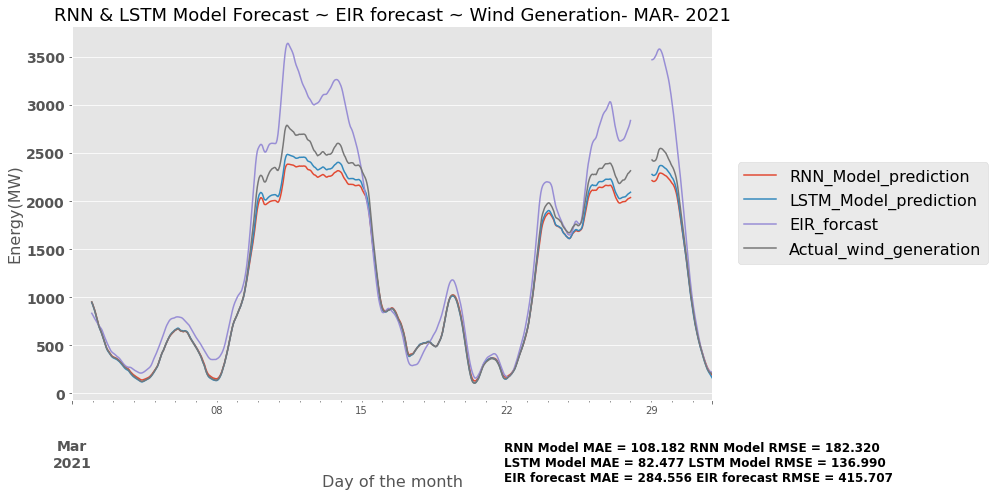

In [71]:
d_mar = {   'datetime': timesteps_mar,
            'RNN_Model_prediction': rnn_pred_mar,
            'LSTM_Model_prediction': lstm_pred_mar,
            'EIR_forcast': wind_f_mar,
            'Actual_wind_generation' : wind_g_mar
        }       
df_mar = pd.DataFrame(data=d_mar)

df_mar_w_rolling = df_mar.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ EIR forecast ~ Wind Generation- MAR- 2019
plt_data.plot_predictions( 
    df = df_mar_w_rolling,
    rnn_results = rnn_results_mar,
    lstm_results =  lstm_results_mar,
    EIR_results = EIR_results_mar,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- MAR- 2021",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

#### APRIL

##### Prediction for the month of April-2020

In [41]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2020,
                                        prev_month = 3, # mar
                                        pred_month = 4, # apr
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
apr_windows, timesteps_apr, wind_g_apr, wind_f_apr = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2856, 30) 
Label shape: (2856, 25)


In [43]:
# prediction evaluation for month of Apr - 2020
EIR_results_apr , rnn_results_apr, lstm_results_apr, rnn_pred_apr, lstm_pred_apr = monthly_prediction( 
                                                                                    windows= apr_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_apr,
                                                                                    eir_pred = wind_f_apr
                                                                                )

Eir forecast data evaluation--
{'mae': 176.3111111111111, 'mse': 88539.08263888888, 'rmse': 297.5551757891112}
RNN Model prediction evaluation--
{'mae': 41.005941274265446, 'mse': 5524.074131583474, 'rmse': 74.32411541070283}
LSTM Model prediction evaluation--
{'mae': 34.90471766723527, 'mse': 3605.9780315030976, 'rmse': 60.04979626529217}


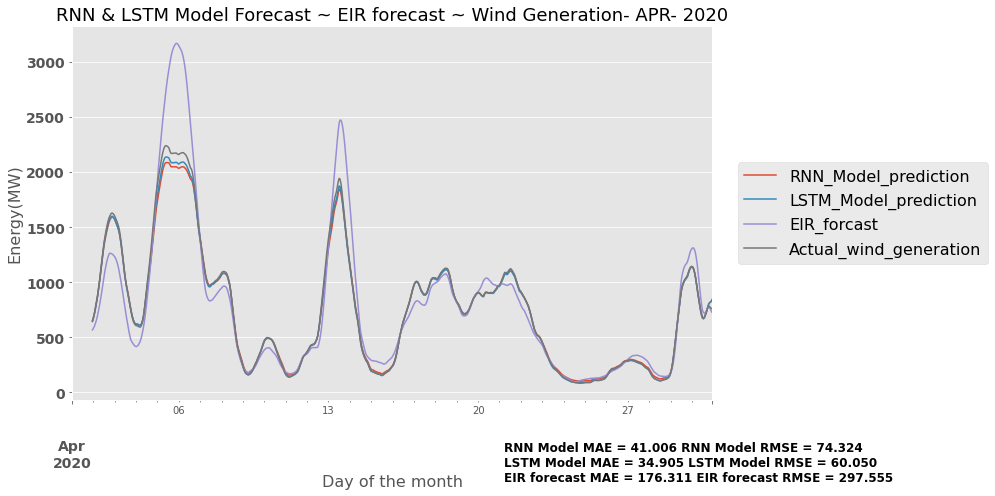

In [46]:
# Plot predictions
d_apr = {   'datetime': timesteps_apr,
            'RNN_Model_prediction': rnn_pred_apr,
            'LSTM_Model_prediction': lstm_pred_apr,
            'EIR_forcast': wind_f_apr,
            'Actual_wind_generation' : wind_g_apr
        }       
df_apr = pd.DataFrame(data=d_apr)

df_apr_w_rolling = df_apr.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg


# Plot Model Forecast ~ EIR forecast ~ Wind Generation- apr- 2020
plt_data.plot_predictions( 
    df = df_apr_w_rolling,
    rnn_results = rnn_results_apr,
    lstm_results =  lstm_results_apr,
    EIR_results = EIR_results_apr,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- APR- 2020",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of April-2021

In [57]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2021,
                                        prev_month = 3, # mar
                                        pred_month = 4, # apr
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
apr_windows, timesteps_apr, wind_g_apr, wind_f_apr = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2856, 30) 
Label shape: (2856, 25)


In [58]:
# prediction evaluation for month of Apr - 2021
EIR_results_apr , rnn_results_apr, lstm_results_apr, rnn_pred_apr, lstm_pred_apr = monthly_prediction( 
                                                                                    windows= apr_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_apr,
                                                                                    eir_pred = wind_f_apr
                                                                                )

Eir forecast data evaluation--
{'mae': 150.90833333333333, 'mse': 38843.00486111111, 'rmse': 197.0862878566419}
RNN Model prediction evaluation--
{'mae': 32.071138567394684, 'mse': 2189.8713193121575, 'rmse': 46.796060937990895}
LSTM Model prediction evaluation--
{'mae': 30.62485473619567, 'mse': 1895.0518841877663, 'rmse': 43.532193652373714}


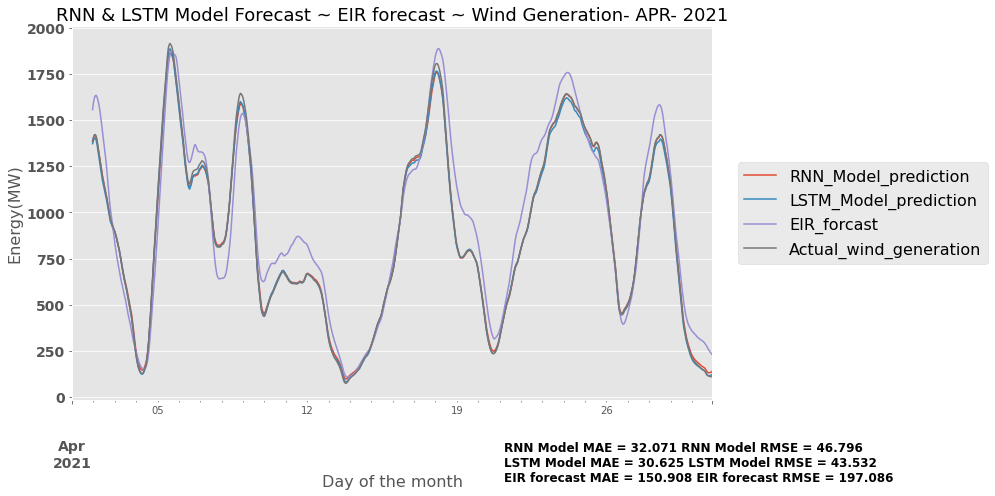

In [59]:
# Plot predictions
d_apr = {   'datetime': timesteps_apr,
            'RNN_Model_prediction': rnn_pred_apr,
            'LSTM_Model_prediction': lstm_pred_apr,
            'EIR_forcast': wind_f_apr,
            'Actual_wind_generation' : wind_g_apr
        }       
df_apr = pd.DataFrame(data=d_apr)

df_apr_w_rolling = df_apr.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg


# Plot Model Forecast ~ EIR forecast ~ Wind Generation- apr- 2021
plt_data.plot_predictions( 
    df = df_apr_w_rolling,
    rnn_results = rnn_results_apr,
    lstm_results =  lstm_results_apr,
    EIR_results = EIR_results_apr,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- APR- 2021",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of April-2019

In [50]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2019,
                                        prev_month = 3, # mar
                                        pred_month = 4, # apr
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
apr_windows, timesteps_apr, wind_g_apr, wind_f_apr = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2856, 30) 
Label shape: (2856, 25)


In [51]:
# prediction evaluation for month of Apr - 2019
EIR_results_apr , rnn_results_apr, lstm_results_apr, rnn_pred_apr, lstm_pred_apr = monthly_prediction( 
                                                                                    windows= apr_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_apr,
                                                                                    eir_pred = wind_f_apr
                                                                                )

Eir forecast data evaluation--
{'mae': 190.078125, 'mse': 70808.80381944444, 'rmse': 266.0992367885418}
RNN Model prediction evaluation--
{'mae': 51.689820626046924, 'mse': 7381.382073946637, 'rmse': 85.91497002238107}
LSTM Model prediction evaluation--
{'mae': 42.928531778521005, 'mse': 4425.608884583643, 'rmse': 66.52524997761108}


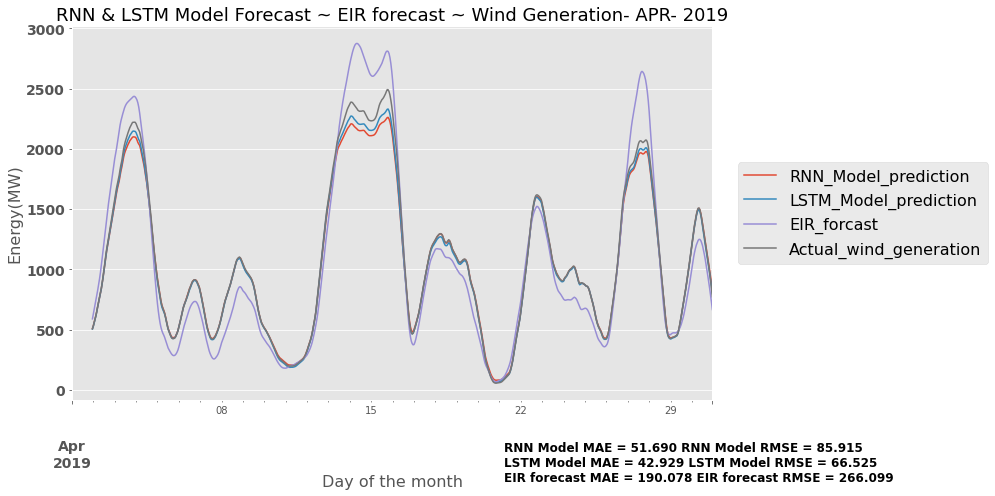

In [56]:
# Plot predictions
d_apr = {   'datetime': timesteps_apr,
            'RNN_Model_prediction': rnn_pred_apr,
            'LSTM_Model_prediction': lstm_pred_apr,
            'EIR_forcast': wind_f_apr,
            'Actual_wind_generation' : wind_g_apr
        }       
df_apr = pd.DataFrame(data=d_apr)

df_apr_w_rolling = df_apr.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg


# Plot Model Forecast ~ EIR forecast ~ Wind Generation- apr- 2019
plt_data.plot_predictions( 
    df = df_apr_w_rolling,
    rnn_results = rnn_results_apr,
    lstm_results =  lstm_results_apr,
    EIR_results = EIR_results_apr,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- APR- 2019",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

#### MAY

##### prediction for the month of May-2019

In [54]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2019,
                                        prev_month = 4, # apr
                                        pred_month = 5, # may
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
may_windows, timesteps_may, wind_g_may, wind_f_may = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2952, 30) 
Label shape: (2952, 25)


In [55]:
# prediction evaluation for month of May - 2019
EIR_results_may , rnn_results_may, lstm_results_may, rnn_pred_may, lstm_pred_may = monthly_prediction( 
                                                                                    windows= may_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_may,
                                                                                    eir_pred = wind_f_may
                                                                                )

Eir forecast data evaluation--
{'mae': 100.76512096774194, 'mse': 20335.480174731183, 'rmse': 142.60252513448415}
RNN Model prediction evaluation--
{'mae': 30.18453908287069, 'mse': 4051.97101986812, 'rmse': 63.65509421773029}
LSTM Model prediction evaluation--
{'mae': 28.62947573136258, 'mse': 3158.2833581011914, 'rmse': 56.19860637152127}


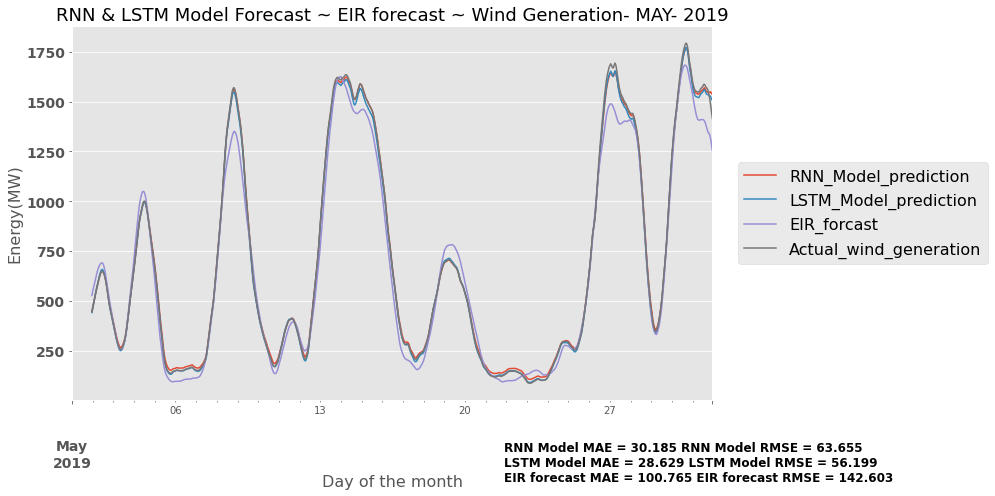

In [61]:
# Plot predictions
d_may = {   'datetime': timesteps_may,
            'RNN_Model_prediction': rnn_pred_may,
            'LSTM_Model_prediction': lstm_pred_may,
            'EIR_forcast': wind_f_may,
            'Actual_wind_generation' : wind_g_may
        }       
df_may = pd.DataFrame(data=d_may)

df_may_w_rolling = df_may.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg


# Plot Model Forecast ~ EIR forecast ~ Wind Generation- May- 2019
plt_data.plot_predictions( 
    df = df_may_w_rolling,
    rnn_results = rnn_results_may,
    lstm_results =  lstm_results_may,
    EIR_results = EIR_results_may,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- MAY- 2019",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### prediction for the month of May-2020

In [62]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2020,
                                        prev_month = 4, # apr
                                        pred_month = 5, # may
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
may_windows, timesteps_may, wind_g_may, wind_f_may = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2952, 30) 
Label shape: (2952, 25)


In [63]:
# prediction evaluation for month of May - 2020
EIR_results_may , rnn_results_may, lstm_results_may, rnn_pred_may, lstm_pred_may = monthly_prediction( 
                                                                                    windows= may_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_may,
                                                                                    eir_pred = wind_f_may
                                                                                )

Eir forecast data evaluation--
{'mae': 217.5440188172043, 'mse': 172479.66565860214, 'rmse': 415.3067127540827}
RNN Model prediction evaluation--
{'mae': 44.106274302287765, 'mse': 4611.154149628014, 'rmse': 67.9054795257939}
LSTM Model prediction evaluation--
{'mae': 36.58387509020426, 'mse': 2891.8421108403422, 'rmse': 53.775850628700816}


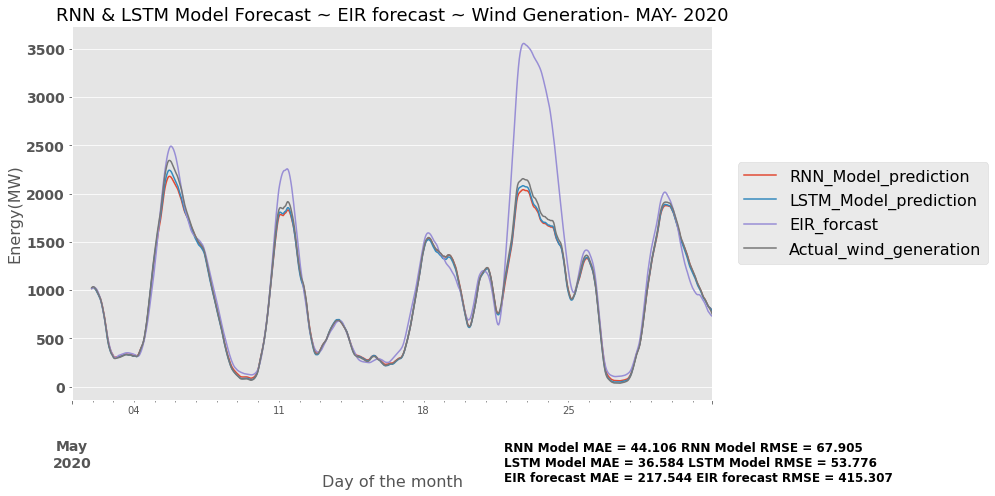

In [64]:
# Plot predictions
d_may = {   'datetime': timesteps_may,
            'RNN_Model_prediction': rnn_pred_may,
            'LSTM_Model_prediction': lstm_pred_may,
            'EIR_forcast': wind_f_may,
            'Actual_wind_generation' : wind_g_may
        }       
df_may = pd.DataFrame(data=d_may)

df_may_w_rolling = df_may.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg


# Plot Model Forecast ~ EIR forecast ~ Wind Generation- May- 2020
plt_data.plot_predictions( 
    df = df_may_w_rolling,
    rnn_results = rnn_results_may,
    lstm_results =  lstm_results_may,
    EIR_results = EIR_results_may,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- MAY- 2020",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### prediction for the month of May-2021

In [66]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2021,
                                        prev_month = 4, # apr
                                        pred_month = 5, # may
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = WIND
                                    )
may_windows, timesteps_may, wind_g_may, wind_f_may = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2833, 30) 
Label shape: (2833, 25)


In [67]:
# prediction evaluation for month of May - 2021
EIR_results_may , rnn_results_may, lstm_results_may, rnn_pred_may, lstm_pred_may = monthly_prediction( 
                                                                                    windows= may_windows,
                                                                                    model_rnn = model_rnn,
                                                                                    model_lstm =  model_lstm,
                                                                                    scaler = norm_scaler,
                                                                                    actual = wind_g_may,
                                                                                    eir_pred = wind_f_may
                                                                                )

Eir forecast data evaluation--
{'mae': 199.40707035351767, 'mse': 90685.1620581029, 'rmse': 301.1397716312193}
RNN Model prediction evaluation--
{'mae': 55.74600738656241, 'mse': 8803.792111509485, 'rmse': 93.82852504174562}
LSTM Model prediction evaluation--
{'mae': 42.38552813000891, 'mse': 4783.0644307419525, 'rmse': 69.15970236157725}


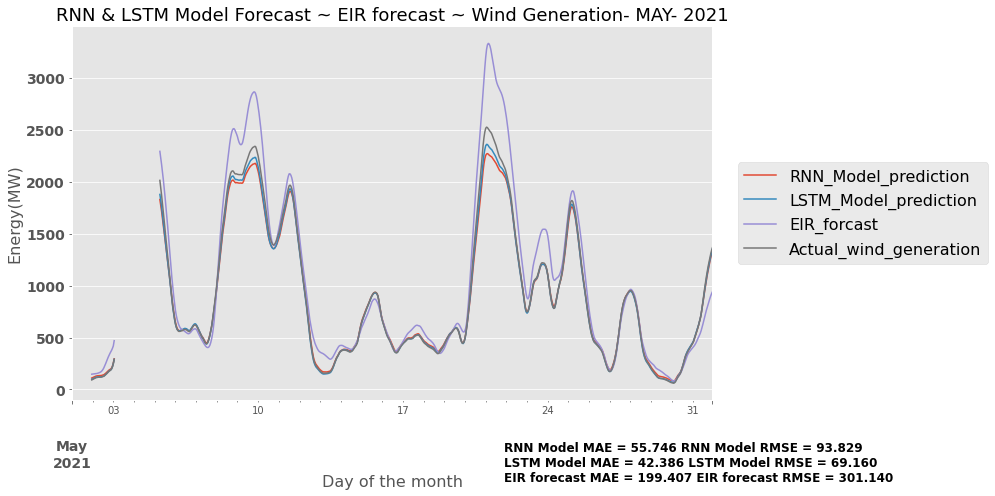

In [68]:
# Plot predictions
d_may = {   'datetime': timesteps_may,
            'RNN_Model_prediction': rnn_pred_may,
            'LSTM_Model_prediction': lstm_pred_may,
            'EIR_forcast': wind_f_may,
            'Actual_wind_generation' : wind_g_may
        }       
df_may = pd.DataFrame(data=d_may)

df_may_w_rolling = df_may.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg


# Plot Model Forecast ~ EIR forecast ~ Wind Generation- May- 2021
plt_data.plot_predictions( 
    df = df_may_w_rolling,
    rnn_results = rnn_results_may,
    lstm_results =  lstm_results_may,
    EIR_results = EIR_results_may,
    title = "RNN & LSTM Model Forecast ~ EIR forecast ~ Wind Generation- MAY- 2021",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)